# Métricas en clasificación

En este Notebook vamos analizar distintas métricas y algoritmos sobre un problema de clasificación desbalanceado. 

## Contenidos

1. Análisis exploratorio
2. Métricas clasificación
3. Comparación clasificadores

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [4]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

# 1. Análisis exploratorio

Vamos a trabajar con datos de fuga de una compañía telefónica. El objetivo es predecir si los clientes van a abandonar la compañía.

<div class = "alert alert-success">
**EJERCICIO**: Cargue los datos *churn.csv* y realice un primer análisis de los datos cargados
</div>

<div class = "alert alert-success">
**EJERCICIO**: Este problema está desbalanceado, calcule el ratio de desbalanceo
</div>

In [7]:
data = pd.read_csv('./data/churn.csv', sep=',', decimal='.')
data.head().T

,0,1,2,3,4
state,KS,OH,NJ,OH,OK
account length,128,107,137,84,75
area code,415,415,415,408,415
phone number,382-4657,371-7191,358-1921,375-9999,330-6626
international plan,no,no,no,yes,yes
voice mail plan,yes,yes,no,no,no
number vmail messages,25,26,0,0,0
total day minutes,265.1,161.6,243.4,299.4,166.7
total day calls,110,123,114,71,113
total day charge,45.07,27.47,41.38,50.9,28.34


In [8]:
data.dtypes

state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

In [9]:
data.shape

(3333, 21)

In [16]:
data["churn"].value_counts()
data["churn"].value_counts()/data.shape[0]

False    0.855086
True     0.144914
Name: churn, dtype: float64

##  1.1 preprocesamiento de variables

Si escribimos *data.dtypes* nos indica el tipo de las variables de nuestro dataframe. Vemos que tenemos variables categóricas que tenemos que codificar. 

<div class = "alert alert-success">
**EJERCICIO**: Elimine la variable *phone number* y codifique las variables categóricas.
</div>

In [17]:
data.columns[data.dtypes == 'object']

Index(['state', 'phone number', 'international plan', 'voice mail plan'], dtype='object')

In [18]:
data.drop('phone number', axis=1, inplace=True)

In [24]:
data.shape

(3333, 20)

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['state'] = le.fit_transform(data['state'])
data['international plan'] = le.fit_transform(data['international plan'])
data['voice mail plan'] = le.fit_transform(data['voice mail plan'])

data["churn"] = le.fit_transform(data['churn'])

data.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


<div class = "alert alert-success">
**EJERCICIO**: Represente el histograma de las variable con distintos colores para cada clase.
</div>

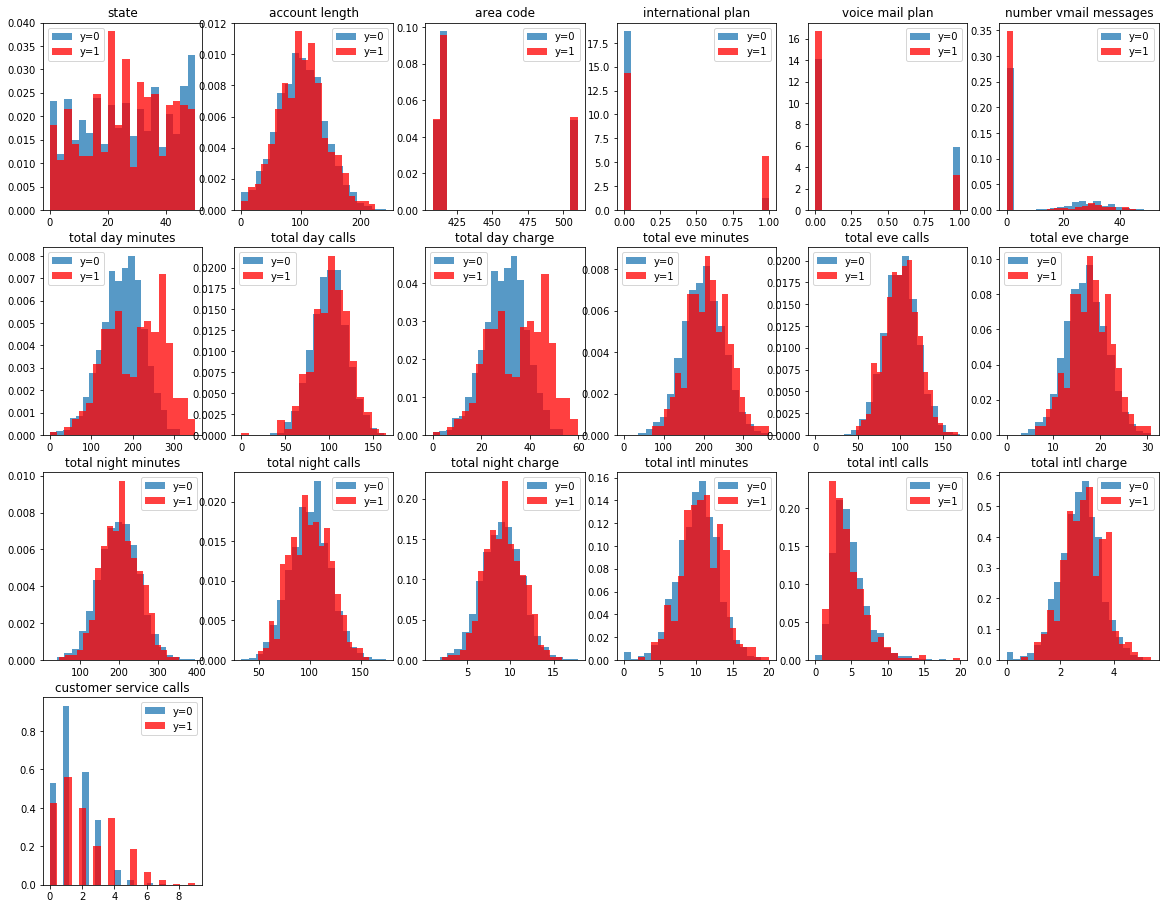

In [29]:
# Pintamos histogramas para cada clase
plt.figure(figsize=(20,20))

idx_0 =  data['churn'] == 0
idx_1 =  data['churn'] == 1

for i,feature in enumerate(data.columns.drop(['churn'])):
    plt.subplot(5,6,i+1)   
    plt.hist(data.ix[idx_0,feature], density=1, alpha=0.75,label='y=0', bins=20)
    plt.hist(data.ix[idx_1,feature], density=1, facecolor='red', alpha=0.75,label='y=1', bins=20)
    plt.legend()
    plt.title(feature)

plt.show()

## 1.2 Correlación entre variables

<div class = "alert alert-success">
**EJERCICIO**: Represente el mapa de correlación entre variables
</div>

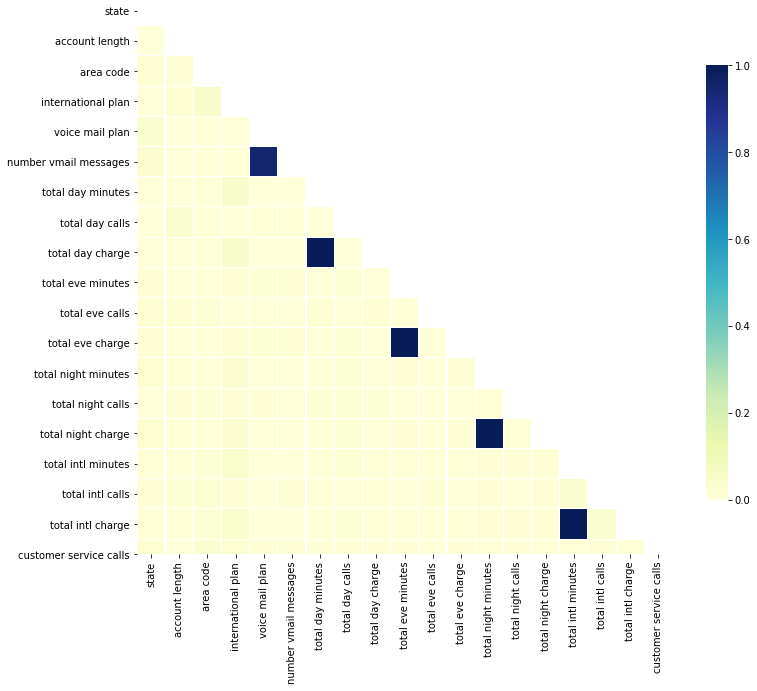

In [30]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['churn'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

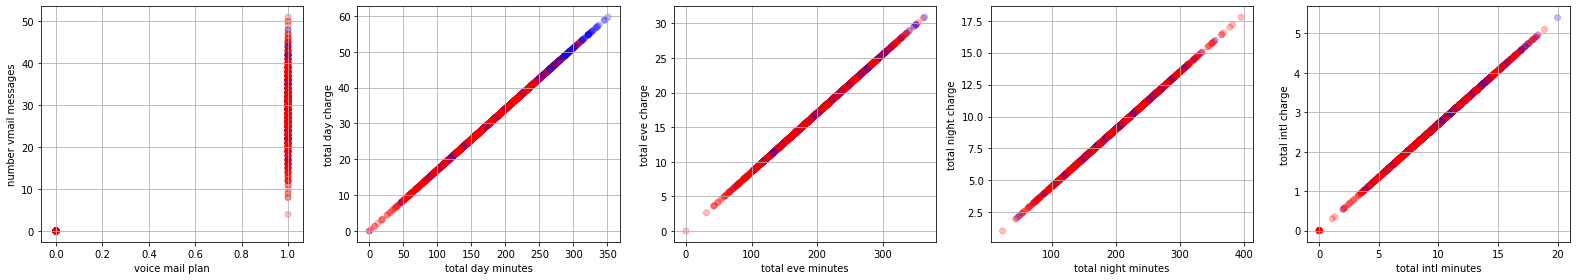

In [31]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
pairs = np.where(upper>0.95)
fx = data.columns[pairs[0]]
fy =  data.columns[pairs[1]]

i=1
plt.figure(figsize=(22,4))
for f1,f2 in zip(fx,fy):
    
    plt.subplot(1,5,i)
    
    plt.scatter(data[f1],data[f2], c=data['churn'],cmap=cm_bright, alpha=0.25)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.grid()
    plt.tight_layout()
    
    i+=1
    
plt.show()

En clasificación, variables correlacionadas no afectan al proceso de clasificación. Sin embargo, dada la correlación extrema y con el objetivo de eliminar variables poco informativas, podemos eliminar algunas columnas.

In [32]:
columns_to_drop = ['total day minutes','total eve minutes','total night minutes','total intl minutes']

# 2. Métricas en clasificación

Vamos a representar la matriz de confusión, y a partir de ella calcular distintas métricas. Para ello, comencemos un clasificador sencillo: regresión logística.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# preparamos los datos

columns_to_drop.append('churn')
features = data.columns.drop(columns_to_drop)

X = data[features].values
y = data['churn'].values


# PASO 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=0)

scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))


Datos train:  (2499, 15)
Datos test:   (834, 15)
Propocion train:0.145
Propocion test: 0.145


## 2.1 Matriz de confusión y métricas

<div class = "alert alert-success">
**EJERCICIO**: Ajuste un algoritmo de regresión logística sobre el conjunto de entrenamiento con $C = 1$. Calcule la predicción para el conjunto de entrenamiento (*y_pred*).
</div>

In [36]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1).fit(Xs_train, y_train)
y_pred = lr.predict(Xs_train)

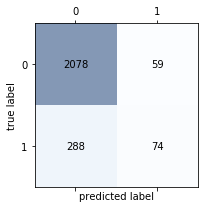

In [37]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_train,y_pred)
plot_confusion_matrix(confmat)

# Podemos acceder a los valores de la matriz
tn, fp, fn, tp = confusion_matrix(y_train,y_pred).ravel()

In [38]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([2137,  362], dtype=int64))

<div class = "alert alert-success">
**EJERCICIO**: A partir de las TP, TN, FP, FN, calcula las siguiente métricas: SEN, ESP, PPV, FSC, ACC.
</div>

ACC:  0.8611444577831132
SEN:  0.20441988950276244
ESP:  0.972391202620496
PPV:  0.556390977443609
FSC:  0.298989898989899


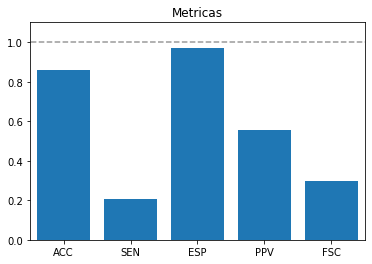

In [39]:
calcula_metricas(confmat)

<div class = "alert alert-success">
**EJERCICIO**: Calcula las métricas de performance en el conjunto de test.
</div>

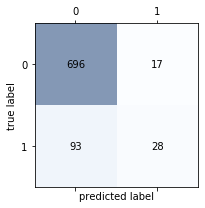

In [40]:
y_pred_test = lr.predict(Xs_test)
confmat_test = confusion_matrix(y_test,y_pred_test)
plot_confusion_matrix(confmat_test)

<div class = "alert alert-success">
**EJERCICIO**: Representa el histograma de probabilidad estimada *y_prob* para el conjunto de test. Representa de distinto color cada una de las clases. 
</div>

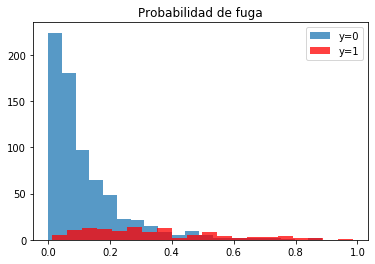

In [47]:
# https://datascience.stackexchange.com/a/22821 echad un ojo, lo que recoge este código es la probabilidad
# de que las instancias pertenezcan a la clase 1 (fugados)

y_prob = lr.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
plt.hist(y_prob[idx_0], density=0, alpha=0.75,label='y=0', bins=20)
plt.hist(y_prob[idx_1], density=0, facecolor='red', alpha=0.75,label='y=1', bins=20)
plt.legend()
plt.title('Probabilidad de fuga')

plt.show()

Por último, vamos a representar la curva ROC.

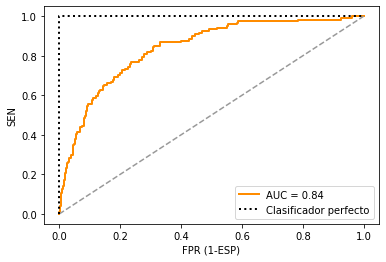

In [46]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

# 3. Comparación clasificadores

Vamos a comparar los siguientes clasificadores: 

* Regresión logística
* Árboles de decisión
* Random Forest

<div class = "alert alert-success">
**EJERCICIO**: Calcule los parámetros libres óptimos para cada clasificador. Ajuste un modelo con dichos parámetros y compare las métricas obtenidas con cada uno de ellos
</div>

## 3.1 Regresión logística

Hemos visto que este algoritmo está sesgado hacia la clase mayoritoria. Para compensar esta situación, podemos asignar pesos distintos a los errores cometidos en cada una de las clases, a través del parámetro [*class_weight*](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Además, podemos trabajar con distintas [métricas](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) a la hora de optimizar los parámetros libres. Para conjuntos desbalancedados es adecuada:

* 'f1': F1-score, compromiso entre SEN, y PPV.


best mean cross-validation score: 0.862
best parameters: {'C': 0.003981071705534973}


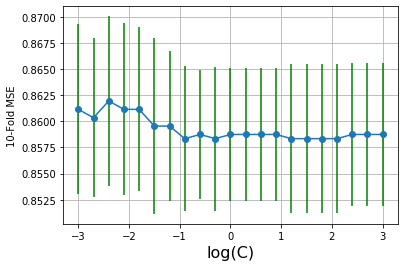

In [52]:
from sklearn.model_selection import GridSearchCV

vectorC = np.logspace(-3,3,21)
param_grid = {'C': vectorC }

grid = GridSearchCV(LogisticRegression(random_state=0),
                    scoring='accuracy', 
                    param_grid=param_grid, 
                    cv = 10)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.grid()
plt.show()

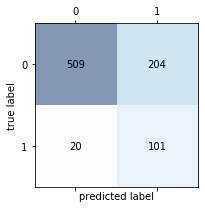

ACC:  0.7314148681055156
SEN:  0.8347107438016529
ESP:  0.7138849929873773
PPV:  0.33114754098360655
FSC:  0.47417840375586856


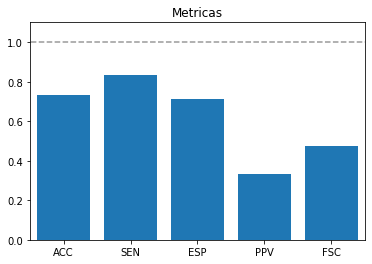

In [53]:
Copt = grid.best_params_['C']

lr = LogisticRegression(random_state=0, C = Copt, class_weight='balanced').fit(Xs_train,y_train)
y_pred = lr.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

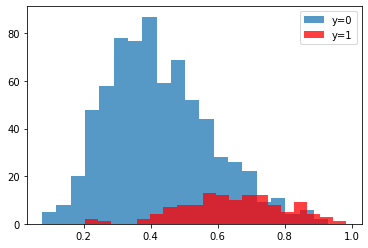

In [54]:
y_prob = lr.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
plt.hist(y_prob[idx_0], density=0, alpha=0.75,label='y=0', bins=20)
plt.hist(y_prob[idx_1], density=0, facecolor='red', alpha=0.75,label='y=1', bins=20)

plt.legend(loc=1)
plt.show()

<div class = "alert alert-success">
**EJERCICIO**: Compare el resultado con respecto a entrenar maximizando *accuracy* y sin balancear las clases.
</div>

<div class = "alert alert-success">
**EJERCICIO**: Una vez fijados los parámetros libres, represente la curva ROC. 
</div>

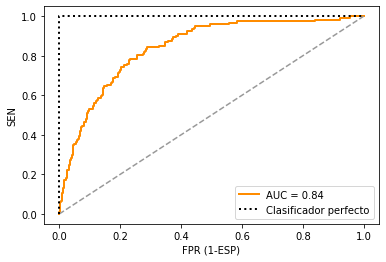

In [55]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

## 3.2 Árboles de decisión

Entrenamos ahora un árbol de decisión. Otra ventaja adicional de los árboles es que por su construcción hace frente al desbalanceo de las clases.

<div class = "alert alert-success">
**EJERCICIO**: Entrena un árbol de decisión y calcula las métricas obtenidas en el conjunto de test.
</div>

best mean cross-validation score: 0.936
best parameters: {'max_depth': 6}


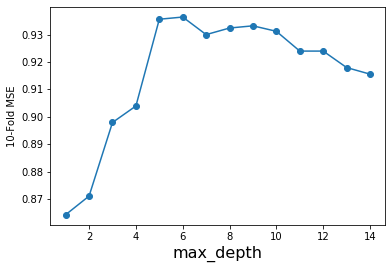

In [64]:
from sklearn.tree import DecisionTreeClassifier

maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth }

#grid = GridSearchCV(DecisionTreeClassifier(random_state=0, class_weight='balanced'),
#                    scoring='f1',
#                    param_grid=param_grid,
#                    cv = 10
#)
grid = GridSearchCV(DecisionTreeClassifier(random_state=0),
                    scoring='accuracy',
                    param_grid=param_grid,
                    cv = 10
)

grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

In [65]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeClassifier(max_depth=maxDepthOptimo).fit(Xs_train,y_train)

print("Score Train: ",treeModel.score(Xs_train,y_train))
print("Score Test: ",treeModel.score(Xs_test,y_test))

Score Train:  0.9631852741096438
Score Test:  0.9544364508393285


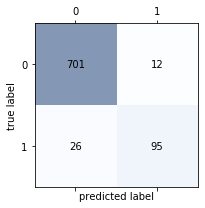

ACC:  0.9544364508393285
SEN:  0.7851239669421488
ESP:  0.9831697054698457
PPV:  0.8878504672897196
FSC:  0.8333333333333334


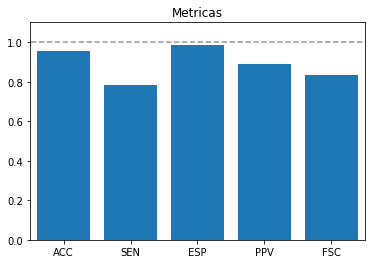

In [66]:
y_pred = treeModel.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

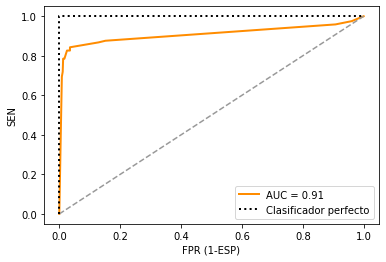

In [67]:
y_prob = treeModel.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

<div class = "alert alert-success">
**EJERCICIO**: Visualiza el árbol de decisión entrenado para comprender las predicciones realizadas.
</div>

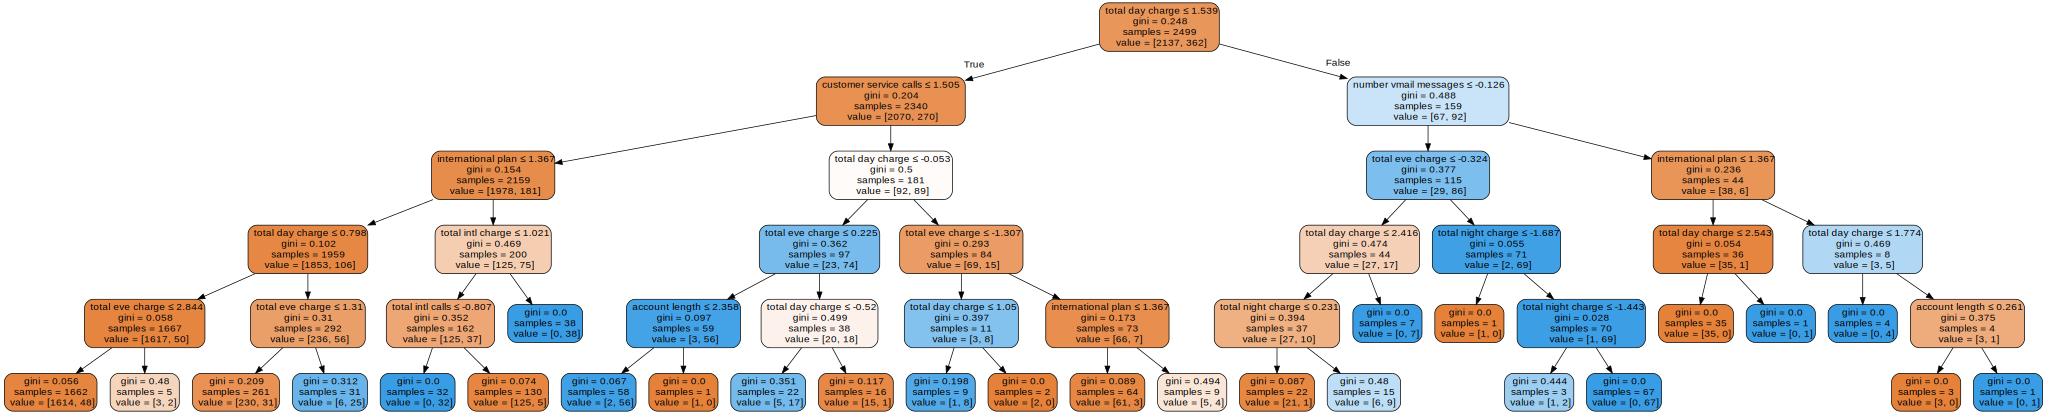

In [60]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(treeModel, out_file=None, 
                         feature_names=features,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 

graph

## 3.3 Random Forest

Comprobemos prestaciones para un algoritmo de Random Forest.

<div class = "alert alert-success">
**EJERCICIO**: Entrena un algoritmo de Random Forest y calcula las métricas obtenidas en el conjunto de test.
</div>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# grid search
maxDepth   = range(1,15)
param_grid = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt'),
                    scoring='f1',
                    param_grid=param_grid,
                    cv=10) 
grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [72]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = RandomForestClassifier(max_depth=maxDepthOptimo-3).fit(Xs_train,y_train)

print("Score Train: ",treeModel.score(Xs_train,y_train))
print("Score Test: ",treeModel.score(Xs_test,y_test))

Score Train:  0.9103641456582633
Score Test:  0.9004796163069544


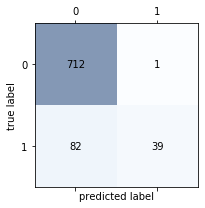

ACC:  0.9004796163069544
SEN:  0.32231404958677684
ESP:  0.9985974754558204
PPV:  0.975
FSC:  0.48447204968944096


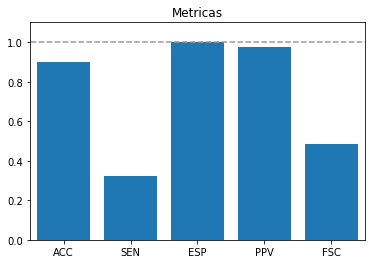

In [73]:
y_pred = treeModel.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

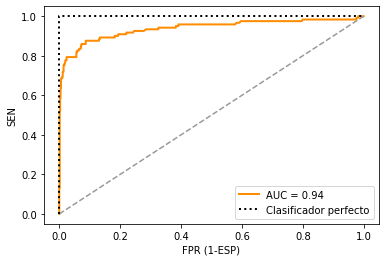

In [74]:
y_prob = treeModel.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

<div class = "alert alert-success">
**EJERCICIO**@home: Entrena una SVM y Boosted Trees
</div>